## Задание
Практическое задание к уроку 8. Рекуррентные нейронные сети RNN LSTM GRU
Данные берем отызывы за лето

На вебинаре мы говорили, что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для нашей задачи

построить свёрточные архитектуры

построить различные архитектуры с RNN

построить совместные архитектуры CNN -> RNN или (RNN -> CNN)


In [121]:
pip install pymorphy2

In [122]:
pip install stop_words

In [137]:
# попробуем запрограммировать простую рекурентную сеть. Возьмем датасет с прошлого занятия

import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
#from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt



In [124]:
batch_size =  1024
n_clases = 2


In [125]:
pd.set_option('max_colwidth', 1200)
pd.set_option('display.width', 1200)
pd.set_option('display.width', 100)

In [126]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_val = pd.read_csv("val.csv")
df_train.head()

,id,text,class
0,0,"@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.",0
1,1,"RT @GalyginVadim: Ребята и девчата!\nВсе в кино!!! ""Вот Это Любовь!""\nСегодня! Завтра! И потом!)))))\n#вотэтолюбовь",1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретвит((((( RT,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Запретный плод. :),1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса не боится мороза и .......)),1


In [127]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):

    txt = str(txt)

    txt = re.sub(r'#\S+', '', txt) # удалит хештеги
    txt = re.sub(r'@\S+', '', txt) # удалит упоминани
    txt = re.sub('\d', '', txt) # удалит упоминани
    txt = re.sub(r'http\S+\s*', '', txt) # удалит URL
    txt = re.sub('RT|cc', '', txt) # удалит RT и cc

    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    #txt = re.sub("\sне", "не", txt)
    txt = re.sub('d', ' ', txt)
    txt = re.sub(r'\s', ' ', txt)

    txt = [morpher.parse(word)[0].normal_form for word in txt.split()]
    return " ".join(txt)

df_train['text1'] = df_train['text'].apply(preprocess_text)
df_val['text1'] = df_val['text'].apply(preprocess_text)
df_test['text1'] = df_test['text'].apply(preprocess_text)

In [128]:
df_train

,id,text,class,text1
0,0,"@alisachachka не уезжаааааааай. :(❤ я тоже не хочу, чтобы ты уезжала.",0,не уезжаааааааать ❤ я тоже не хотеть чтобы ты уезжать
1,1,"RT @GalyginVadim: Ребята и девчата!\nВсе в кино!!! ""Вот Это Любовь!""\nСегодня! Завтра! И потом!)))))\n#вотэтолюбовь",1,ребята и девчата всё в кино вот это любовь сегодня завтра и потом
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретвит((((( RT,0,кто ненавидеть пробка ретвит
3,3,RT @epupybobv: Хочется котлету по-киевски. Запретный плод. :),1,хотеться котлета покиевск запретный плод
4,4,@KarineKurganova @Yess__Boss босапопа есбоса не боится мороза и .......)),1,босапоп есбосой не бояться мороз и
...,...,...,...,...
181462,181462,Классным будет новый год..( http://t.co/LejaGuXNwu,0,классный быть новый год
181463,181463,Видишь человека хочешь сказать ему привет . А он тебя игнорит :(,0,видеть человек хотеть сказать он привет а он ты игнорита
181464,181464,@Julia6_9Styles там длинный диагноз. Вкратце: аллергический отёк горла с осложнением в виде фолликулярной ангины :(,0,там длинный диагноз вкратце аллергический отечь горло с осложнение в вид фолликулярный ангина
181465,181465,"@technoslav ух ты, а кому тот серенький кнопочне телефон достанется ;)",1,ух ты а кто тот серенький кнопочень телефон достаться


In [129]:
text_corpus_train = df_train['text1'].values
text_corpus_valid = df_val['text1'].values
text_corpus_test = df_test['text1'].values

In [130]:
text_corpus_train

array(['не уезжаааааааать ❤ я тоже не хотеть чтобы ты уезжать',
       'ребята и девчата всё в кино вот это любовь сегодня завтра и потом',
       'кто ненавидеть пробка ретвит', ...,
       'там длинный диагноз вкратце аллергический отечь горло с осложнение в вид фолликулярный ангина',
       'ух ты а кто тот серенький кнопочень телефон достаться',
       'я тоже так собираться сделать навешать фотка вандюхий обязательно выложить фотка как нарядить'],
      dtype=object)

## Создание входного вектора

In [131]:
tokenizer = Tokenizer(num_words=None,
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)



In [132]:
X_train, y_train

(array([[     0,      0,      0, ...,    126,      9,    687],
        [     0,      0,      0, ...,     66,      3,    114],
        [     0,      0,      0, ...,    251,    762,    707],
        ...,
        [     0,      0,      0, ...,    567, 135437,   4011],
        [     0,      0,      0, ..., 135438,    176,   2914],
        [     0,      0,      0, ...,    210,     13,   2557]], dtype=int32),
 array([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]], dtype=float32))

In [133]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [57]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes, dtype=np.int32)
y_val= keras.utils.to_categorical(y_val, num_classes, dtype=np.int32)

In [134]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))

## SimpleRNN сеть

In [109]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=keras.optimizers.experimental.Nadam(
    learning_rate=0.0007, beta_1=0.85, ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


early_stopping=EarlyStopping(monitor='val_loss')

history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 32, 30)            4063170   
                                                                 
 masking_14 (Masking)        (None, 32, 30)            0         
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 128)               20352     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4091843 (15.61 MB)
Trainable params: 40

In [110]:
model.evaluate(X_valid, y_val, batch_size=1024, verbose=1)

23/23 [==============================] - 0s 6ms/step - loss: 0.5948 - accuracy: 0.7178


[0.594822108745575, 0.7177621722221375]

In [111]:
history.history

{'loss': [0.6315810084342957, 0.4768015742301941, 0.36169907450675964],
 'accuracy': [0.6300636529922485, 0.7769899368286133, 0.8450036644935608],
 'val_loss': [0.5433828234672546, 0.5317386984825134, 0.5910229086875916],
 'val_accuracy': [0.7246927618980408, 0.7350526452064514, 0.7191271185874939]}

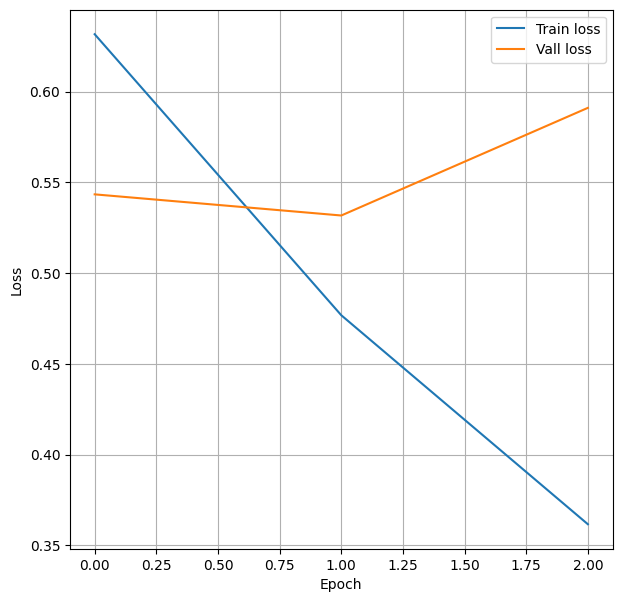

In [112]:
plt.figure(figsize = (7, 7))
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Vall loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

## LSTM

In [115]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(128, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(
    optimizer=keras.optimizers.experimental.Nadam(
    learning_rate=0.0007, beta_1=0.85, ema_momentum=0.9) , loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 32, 30)            4063170   
                                                                 
 masking_17 (Masking)        (None, 32, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               81408     
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4152899 (15.84 MB)
Trainable params: 41

In [116]:
model.evaluate(X_valid, y_val, batch_size=512, verbose=1)


45/45 [==============================] - 1s 13ms/step - loss: 0.5745 - accuracy: 0.7227


[0.5744757056236267, 0.722655713558197]

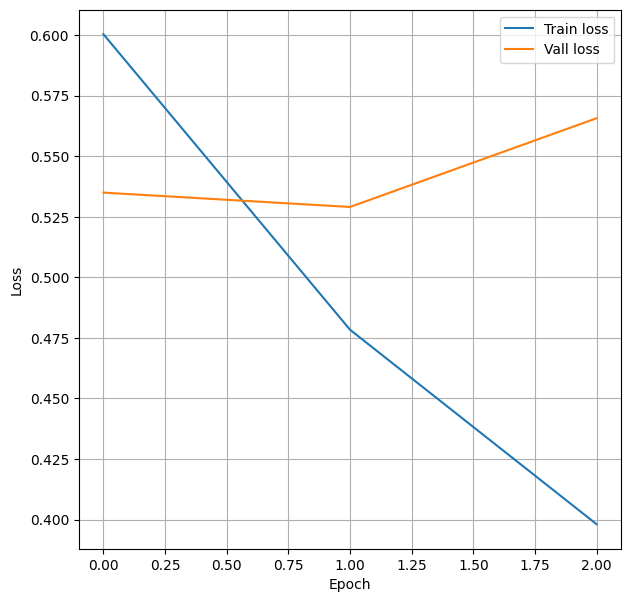

In [117]:
plt.figure(figsize = (7, 7))
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Vall loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Convulation net для обработки последовательностей

In [138]:
model = Sequential()
model.add(Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Conv1D(30, 16))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(1)) #2
model.add(Activation('sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.experimental.Nadam(
    learning_rate=0.0007, beta_1=0.85, ema_momentum=0.9),
              metrics=['accuracy'])



early_stopping=EarlyStopping(monitor='val_loss')


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 32, 30)            4063170   
                                                                 
 conv1d_6 (Conv1D)           (None, 17, 30)            14430     
                                                                 
 activation_8 (Activation)   (None, 17, 30)            0         
                                                                 
 global_max_pooling1d_2 (Gl  (None, 30)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_39 (Dense)            (None, 16)                496       
                                                                 
 activation_9 (Activation)   (None, 16)                0         
                                                     

In [139]:
model.evaluate(X_valid, y_val, batch_size=512, verbose=1)

45/45 [==============================] - 0s 4ms/step - loss: 0.5612 - accuracy: 0.7270


[0.5612140893936157, 0.727020263671875]

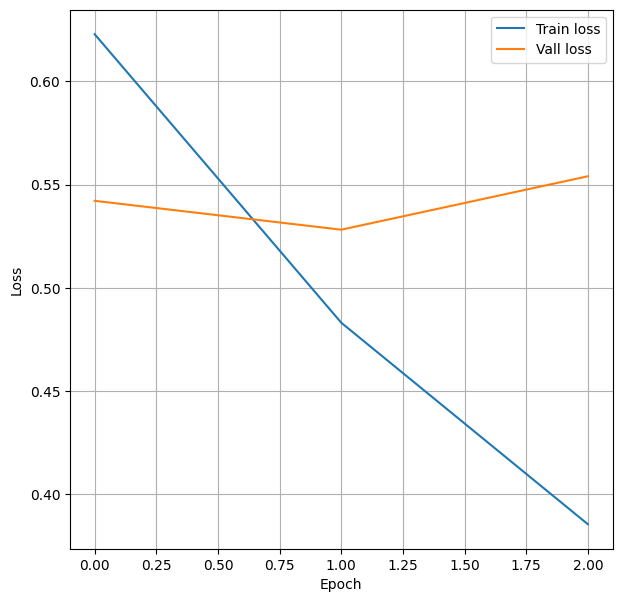

In [140]:
plt.figure(figsize = (7, 7))
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Vall loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

# Комбинация lstm и conv1d

##  conv1d + LSTM

In [141]:
model = Sequential()
model.add(Embedding(input_dim=word_count,
                    input_length=training_length,
                    output_dim=30,
                    trainable=True,
                    mask_zero=True))
model.add(Masking(mask_value=0.0))

model.add(Conv1D(30, 2))
model.add(Activation("relu"))

model.add(Conv1D(16, 2))
model.add(Activation("relu"))
model.add(MaxPooling1D())

model.add(LSTM(16,return_sequences=True))

model.add(LSTM(16))

model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.experimental.Nadam(
    learning_rate=0.0007, beta_1=0.85, ema_momentum=0.9),
              metrics=['accuracy'])



early_stopping=EarlyStopping(monitor='val_loss')


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 32, 30)            4063170   
                                                                 
 masking_19 (Masking)        (None, 32, 30)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 31, 30)            1830      
                                                                 
 activation_11 (Activation)  (None, 31, 30)            0         
                                                                 
 conv1d_8 (Conv1D)           (None, 30, 16)            976       
                                                                 
 activation_12 (Activation)  (None, 30, 16)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 16)          

## LSTM + conv1d

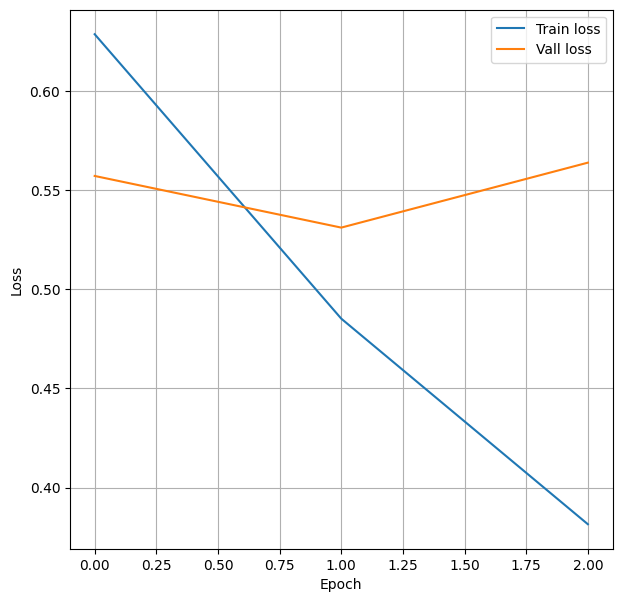

In [142]:
plt.figure(figsize = (7, 7))
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Vall loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [143]:
model = Sequential()
model.add(Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))

model.add(Masking(mask_value=0.0))
model.add(LSTM(32,return_sequences=True))


model.add(Conv1D(32, 3))
model.add(Activation("relu"))

model.add(MaxPooling1D(3))
model.add(Activation("relu"))

model.add(Conv1D(16, 3))
model.add(Activation("relu"))

model.add(GlobalMaxPool1D())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation('sigmoid'))


In [144]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.experimental.Nadam(
    learning_rate=0.0007, beta_1=0.85, ema_momentum=0.9),
              metrics=['accuracy'])



early_stopping=EarlyStopping(monitor='val_loss')


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
160/160 [==============================] - 27s 132ms/step - loss: 0.6214 - accuracy: 0.6392 - val_loss: 0.5611 - val_accuracy: 0.7079
Epoch 2/10
160/160 [==============================] - 12s 76ms/step - loss: 0.4892 - accuracy: 0.7664 - val_loss: 0.5355 - val_accuracy: 0.7271
Epoch 3/10
160/160 [==============================] - 9s 55ms/step - loss: 0.4009 - accuracy: 0.8211 - val_loss: 0.5697 - val_accuracy: 0.7249


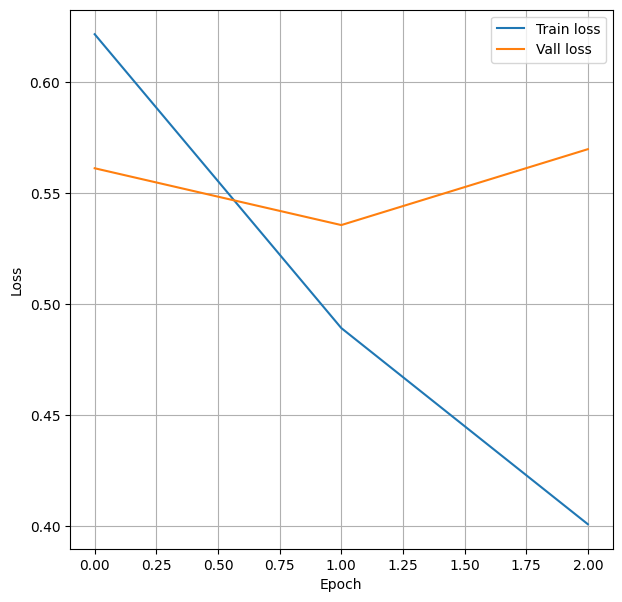

In [145]:
plt.figure(figsize = (7, 7))
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Vall loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Выводы
В целом разделение у всех моделей одинаковое. Скорей всего наборы либо плохо разделимы либо можно изменить обработку данных не убирая знаки смайлы и символы пунктуации. Положительная класификация скорей всего там где есть ) :D а отрицательная там где (((